In [311]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Dutch parliament as an Ising ferromagnet

Data van tweede kamer verkiezingen na 2008:

- 22 november 2023
- 17 maart 2021
- 15 maart 2017
- 12 september 2012
- 9 juni 2010

Zoek opdracht voor moties over een bepaalde periode:

In [231]:
# Periode kabinet Rutte III
search_query = "?$filter=Verwijderd eq false and Vergissing eq false and ((year(GewijzigdOp) eq 2012 and month(GewijzigdOp) ge 10) or (year(GewijzigdOp) ge 2013 and year(GewijzigdOp) le 2016) or (year(GewijzigdOp) eq 2017 and month(GewijzigdOp) le 2)) & orderby=GewijzigdOp"

In [234]:
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"
response = requests.get(url)
data = response.json()
data; 

Moties tijdens kabinet Rutte III:

In [233]:
# Define the initial URL
url = url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"

# Initialize an empty list to store all the data points
all_data = []

# Loop to fetch all pages of data
while url:
    # Make an HTTP GET request to the current URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the JSON response to a Python dictionary
        data = response.json()
        
        # Extract the 'value' part of the JSON response and append it to the list
        all_data.extend(data['value'])
        
        # Check if there's a next page link
        if '@odata.nextLink' in data:
            # Update the URL to fetch the next page of data
            url = data['@odata.nextLink']
        else:
            # If there's no next page link, exit the loop
            url = None
    else:
        # If the request was not successful, print an error message and exit the loop
        print("Error:", response.status_code)
        url = None

# Convert the list of data points to a Pandas DataFrame
df = pd.DataFrame(all_data).sort_values(by='GewijzigdOp')

# Raw data array containing most motions during Rutte III. 
df


Hoeveel moties waren er?

In [280]:
df['Besluit_Id'].nunique()

636

Partijen:

In [281]:
parties = df['ActorFractie'].unique()
parties

array(['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PvdA',
       'PvdD', 'PVV', 'SGP', 'SP', 'VVD', 'Bontes', 'Van Vliet',
       'Van Klaveren', 'GrBvK', '50PLUS/Baay-Timmerman', '50PLUS/Klein',
       'Klein', 'GrKÖ', 'Houwers', 'Monasch'], dtype=object)

We negeren de ondestaande afgesplinterde partijen (in haakjes hun originele partij):
- Bontes (PVV)
- Van Vliet (PVV) (sloot zich niet aan bij de tweede kamer fractie van de VVD in 2018)
- Klein (50Plus)
- Houwers (VVD)
- 50PLUS/Klein (50Plus)
- 50PLUS/Baay-Timmerman (50Plus)
- Van Klaveren (PVV)
- GrBvK (PVV)
- GrKÖ (PvdA)




In [282]:
# Parties to ignore
ignore_parties = ['Klein', 'GrKÖ', 'Van Vliet', '50PLUS/Klein', 'Houwers', 'Van Klaveren', 'GrBvK', 'Bontes', '50PLUS/Baay-Timmerman', 'Monasch']
# Create a boolean mask to mark the elements you want to keep
mask = np.isin(parties, ignore_parties, invert=True)
# Filter out the elements you want to keep
filtered_parties = parties[mask]
filtered_parties

array(['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PvdA',
       'PvdD', 'PVV', 'SGP', 'SP', 'VVD'], dtype=object)

Process the dataframe:

In [341]:
# Remove ignored parties
processed_df = df[df['ActorFractie'].isin(filtered_parties)]

# Only keep cases where ActorNaam == ActorFractie, i.e. people voted as a party
processed_df = processed_df[processed_df['ActorNaam'] == processed_df['ActorFractie']]

# Keep only relevant columns 
processed_df = processed_df[['Besluit_Id','Soort', 'ActorFractie']]

# Replace votes with numerical values
processed_df['Soort'] = processed_df['Soort'].map({'Voor': 1, 'Tegen': -1})
processed_df = processed_df.reset_index(drop=True)

processed_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1.0,50PLUS
1,57e214d1-785a-4094-b9c9-348c6d587464,1.0,CDA
2,57e214d1-785a-4094-b9c9-348c6d587464,1.0,ChristenUnie
3,57e214d1-785a-4094-b9c9-348c6d587464,1.0,D66
4,57e214d1-785a-4094-b9c9-348c6d587464,1.0,GroenLinks
...,...,...,...
6842,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1.0,PvdA
6843,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1.0,SGP
6844,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1.0,PvdD
6845,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1.0,PVV


Gemiddelde stem per fractie: 

In [338]:
mean_votes = processed_df.groupby('ActorFractie')['Soort'].mean().reset_index()
mean_votes.columns = ['ActorFractie', 'Mean Vote']
mean_votes

,ActorFractie,Mean Vote
0,50PLUS,0.767123
1,CDA,0.750799
2,ChristenUnie,0.770335
3,D66,0.824281
4,GroenLinks,0.680000
5,PVV,0.277955
6,PvdA,0.968051
7,PvdD,0.382400
8,SGP,0.789474
9,SP,0.513600


In [322]:
pivot_df = processed_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
pivot_df


ActorFractie,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
Besluit_Id,,,,,,,,,,,
0001864e-d3c6-4624-a93f-a0f8dd4c04cc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011086ac-713f-455c-bd37-22591ad5ceb4,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
01eb5f6c-1a76-4c13-bdb1-c8d7eb9e6ca7,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0
02257872-4505-4fcc-b545-6ae5f15efefd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02435d6f-a53b-4791-91ce-3f1d098e7f1b,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
fec0ce7a-dfcd-43b0-a1b2-69d8ea1341b6,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
fefa9414-00c9-4e33-bb3c-0baeafe18863,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
ff078a51-edeb-4146-8580-a212222ed2f4,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0


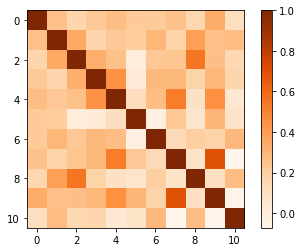

In [332]:
correlation_matrix = pivot_df.corr()
plt.imshow(correlation_matrix, cmap='Oranges')
plt.colorbar()

In [285]:
filtered_df.groupby('Besluit_Id')['FractieGrootte'].sum()

Besluit_Id
0001864e-d3c6-4624-a93f-a0f8dd4c04cc     143
003a78db-4c18-400d-8708-adb9e99b0f60    3633
011086ac-713f-455c-bd37-22591ad5ceb4     143
01eb5f6c-1a76-4c13-bdb1-c8d7eb9e6ca7     150
02257872-4505-4fcc-b545-6ae5f15efefd     150
                                        ... 
fec0ce7a-dfcd-43b0-a1b2-69d8ea1341b6     145
fefa9414-00c9-4e33-bb3c-0baeafe18863     150
ff078a51-edeb-4146-8580-a212222ed2f4     149
ff17d6d3-3ac1-4a2d-a26b-51cca283bcf3     145
fffbf7fd-a1e0-49dd-9546-85b9d4e3e36a     150
Name: FractieGrootte, Length: 636, dtype: int64

In [211]:
df[df['Besluit_Id'] == '03002d6b-8718-4057-8c6b-7f92e4c42ad8']

,Id,Besluit_Id,Soort,FractieGrootte,ActorNaam,ActorFractie,Vergissing,SidActorLid,SidActorFractie,Persoon_Id,Fractie_Id,GewijzigdOp,ApiGewijzigdOp,Verwijderd
7709,360dc730-02b3-4f47-888d-b793b4537aba,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Tegen,4,50PLUS,50PLUS,False,None,S-1-365867521-2120874753-800324394-1119149088-...,None,a34bf6c8-834e-4dba-b4d2-f2f1b3957bd2,2017-07-07T11:01:05.417+02:00,2019-07-26T11:41:15.4784367Z,False
3511,74b8de12-ecc8-4f0d-8567-547054244992,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,19,D66,D66,False,None,S-1-365867521-2120874753-1399399692-1206643224...,None,4e9f6f5b-2544-4667-8134-6b85c4ebb4e0,2017-07-07T11:01:05.433+02:00,2019-07-26T13:04:49.3475311Z,False
389,65fc2aac-b5f3-4f8a-a823-090ecd13b57b,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,3,DENK,DENK,False,None,S-1-365867521-2120874753-3073972497-1296662242...,None,deb74bb5-63a9-4ffc-98ed-af577167452e,2017-07-07T11:01:05.433+02:00,2019-07-26T12:56:19.8152991Z,False
2774,aabf36ed-9ed9-4341-9a15-42bec2eecbc1,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,19,CDA,CDA,False,None,S-1-365867521-2120874753-3726368973-1295802169...,None,62c1a13c-85ff-40ed-90f7-a9546d61f869,2017-07-07T11:01:05.433+02:00,2019-07-26T12:58:57.5031052Z,False
4199,fc1ab9b3-c98d-43b2-b0de-6474111b44d8,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,5,ChristenUnie,ChristenUnie,False,None,S-1-365867521-2120874753-1996180723-1207380569...,None,d720f5af-0516-408a-b830-0b6ffb8a581c,2017-07-07T11:01:05.433+02:00,2019-07-26T13:04:48.3631576Z,False
998,01daf7fd-0d4e-4123-ad9b-17b5d5bd4403,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Tegen,5,PvdD,PvdD,False,None,S-1-365867521-2120874753-3375217526-1184288014...,None,d3b4d880-ef37-4ce6-99ec-4940266ac466,2017-07-07T11:01:05.447+02:00,2019-07-26T12:59:20.034392Z,False
8180,1ab4184a-95c4-44e2-9648-c29c0fbbf243,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,14,GroenLinks,GroenLinks,False,None,S-1-365867521-2120874753-2386850707-1282307975...,None,8fd1a907-0355-4d27-8dc1-fd5a531b471e,2017-07-07T11:01:05.447+02:00,2019-07-26T13:04:49.9881596Z,False
2548,428ecbf0-094b-4500-871b-3da33913798e,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Tegen,9,PvdA,PvdA,False,None,S-1-365867521-2120874753-2900001417-1207812138...,None,8d46d23c-4f20-49be-b279-5439a2ef8d17,2017-07-07T11:01:05.447+02:00,2019-07-26T13:04:49.1912808Z,False
3389,52676c9f-d7e5-4c6a-a448-51384dbb5dda,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,3,SGP,SGP,False,None,S-1-365867521-2120874753-1520352372-1191064225...,None,77f9b6f1-b1a9-4d1b-a05e-9936e79d8fa5,2017-07-07T11:01:05.463+02:00,2019-07-26T13:04:49.7850279Z,False
9755,f7ee01d8-fe60-46f7-b1fe-e950410b0823,03002d6b-8718-4057-8c6b-7f92e4c42ad8,Voor,20,PVV,PVV,False,None,S-1-365867521-2120874753-203711267-1259409971-...,None,65129918-f256-4975-9da4-488da34d6695,2017-07-07T11:01:05.463+02:00,2019-07-19T11:51:22.8406233Z,False


In [276]:
df.columns

Index(['Id', 'Besluit_Id', 'Soort', 'FractieGrootte', 'ActorNaam',
       'ActorFractie', 'Vergissing', 'SidActorLid', 'SidActorFractie',
       'Persoon_Id', 'Fractie_Id', 'GewijzigdOp', 'ApiGewijzigdOp',
       'Verwijderd'],
      dtype='object')

- PVV stemt graag tegen
- Negeert WIE de motie voortbracht